# Correlation matrices visualization of CIFAR-100 models

In [1]:
import numpy as np
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn

from mdistiller.models import cifar_model_dict
from mdistiller.dataset import get_dataset
from mdistiller.engine.utils import load_checkpoint
from mdistiller.engine.cfg import CFG as cfg

In [2]:
# visualize the difference between the teacher's output logits and the student's
def get_output_metric(model, val_loader, num_classes=100):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for i, (data, labels) in tqdm(enumerate(val_loader)):
            outputs, _ = model(data)
            preds = outputs
            all_preds.append(preds.data.cpu().numpy())
            all_labels.append(labels.data.cpu().numpy())
    
    all_preds = np.concatenate(all_preds, 0)
    all_labels = np.concatenate(all_labels, 0)
    matrix = np.zeros((num_classes, num_classes))
    cnt = np.zeros((num_classes, 1))
    for p, l in zip(all_preds, all_labels):
        cnt[l, 0] += 1
        matrix[l] += p
    matrix /= cnt
    return matrix

def get_tea_stu_diff(tea, stu, mpath, max_diff):
    cfg.defrost()
    cfg.DISTILLER.STUDENT = stu
    cfg.DISTILLER.TEACHER = tea
    cfg.DATASET.TYPE = 'cifar100'
    cfg.freeze()
    train_loader, val_loader, num_data, num_classes = get_dataset(cfg)
    model = cifar_model_dict[cfg.DISTILLER.STUDENT][0](num_classes=num_classes)
    model.load_state_dict(load_checkpoint(mpath)["model"])
    tea_model = cifar_model_dict[cfg.DISTILLER.TEACHER][0](num_classes=num_classes)
    tea_model.load_state_dict(load_checkpoint(cifar_model_dict[cfg.DISTILLER.TEACHER][1])["model"])
    print("load model successfully!")
    ms = get_output_metric(model, val_loader)
    mt = get_output_metric(tea_model, val_loader)
    diff = np.abs((ms - mt)) / max_diff
    for i in range(100):
        diff[i, i] = 0
    print('max(diff):', diff.max())
    print('mean(diff):', diff.mean())
    seaborn.heatmap(diff, vmin=0, vmax=1.0, cmap="vlag")
    plt.show()

In [4]:
# set a common max-value of the difference for fair comparsion between different methods
MAX_DIFF = 3.0

Files already downloaded and verified
Files already downloaded and verified
load model successfully!


157it [00:23,  6.67it/s]
157it [01:33,  1.68it/s]


max(diff): 0.7952059471855559
mean(diff): 0.0960639261415067


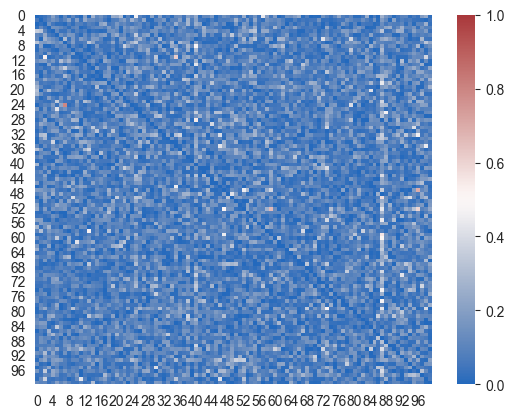

In [5]:
# KD baseline
mpath = "../../download_ckpts/cifar_students/crld_kd_res8x4_7718"
get_tea_stu_diff("resnet32x4", "resnet8x4", mpath, MAX_DIFF)

Files already downloaded and verified
Files already downloaded and verified
load model successfully!


157it [00:20,  7.75it/s]
157it [01:25,  1.84it/s]


max(diff): 2.563812139307459
mean(diff): 0.32185104017706173


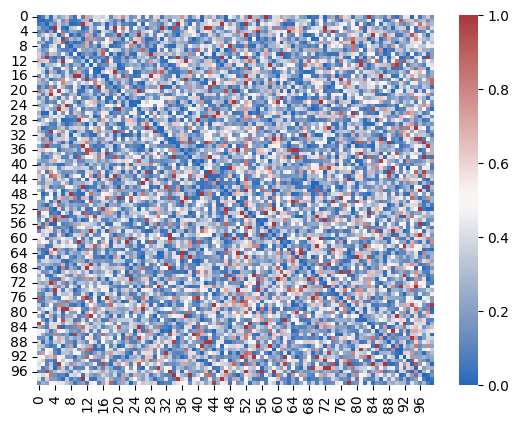

In [56]:
# Our DKD
mpath = "../../download_ckpts/cifar_students/normkd_res8x4_7632"
get_tea_stu_diff("resnet32x4", "resnet8x4", mpath, MAX_DIFF)